<a href="https://colab.research.google.com/github/tennerx97/Kaggle_Competition_NLP/blob/main/Medfai%26Uberti_Natural_Language_Processing_with_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle competition

Nella competizione [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview)  andremo a lavorare con un insieme di post di Twitter. il goal è quello di predirre se un tweet riguarda un disastro oppure no.

Approcceremo il problema nel seguente modo:
1. **Exploratory data analysis:** controlleremo il dataset per poi effettuare operazioni di pulizia.
2. **Feature engineering:** dobbiamo capire quali features ci sono.
3. **Modelling:** scelta di un modello adatto.
4. **Training:** allenamento del modello con il training set
5. **Model evaluation:** si prova a predirre se un tweet riguarda un disastro oppure no, e si valuta la performance di un modello.

# Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import string
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.cluster import dbscan
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import torch
from torch import nn
 
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

# Constants
RND_SEED = 11
use_drive = True
save_model = False

In [ ]:
!pip install transformers
import transformers
from transformers import AdamW, BertConfig, BertModel, BertTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
from torch.optim import lr_scheduler
from torch import nn
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score

# select device
if torch.cuda.is_available():        
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("device:", device)

     |████████████████████████████████| 2.8 MB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 39.4 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
     |████████████████████████████████| 895 kB 40.1 MB/s 
     |████████████████████████████████| 636 kB 46.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
device: cuda


Caricamento dei 3 insiemi di dati da google drive.

In [ ]:
if use_drive:
  drive_name = '/content/drive'
  drive.mount(drive_name)
  drive_folder = 'Colab Notebooks/Twitter fn' # Files location in Google Drive
  drive_location = drive_name + '/My Drive/' + drive_folder + '/'
else:
  drive_location = './'
 
TRAIN_PATH = drive_location + 'datasets/train.csv'
TEST_PATH = drive_location + 'datasets/test.csv'
SUBMISSION_PATH = drive_location + 'datasets/sample_submission.csv'
RESULT_PATH = drive_location + 'datasets/resultsNLP - resultsNLP (2).csv'
 
train = pd.read_csv(TRAIN_PATH).loc[:,["text","target"]]
train_full = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)["text"]
test_full = pd.read_csv(TEST_PATH)
sample_submission = pd.read_csv(SUBMISSION_PATH, index_col='id')
results = pd.read_csv(RESULT_PATH)

Mounted at /content/drive


In [ ]:
train_full.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test_full.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Exploratory Data Analysis

Cominciamo andando ad esplorare il contenuto del dataset. In riferimento alla descrizione dei dati forniti dalla competizione abbiamo: il training set composto da un singolo file train.csv, che si compone dei segenti attributi:

- `ID` - identificatore unico dei tweet
- `text` - testo del tweet
- `location` - la posizione dove il tweet è stato condiviso (può essere vuoto)
- `keyword` - è una keyword particolare di un tweet (può essere vuoto)
- `target` - solo nel file train.csv, questo indica se un tweet è un disastro (1) o no (0)

## Count missing values in columns


Andiamo a vedere alcune informazioni riguardanti i dati di training:

In [ ]:
print("\n-----------Informations-----------")
print(train_full.info())
print("\n----------Null values-----------")
print(train_full.isnull().sum())
print("\n----------Shape of Data----------")
print(train.shape)


-----------Informations-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

----------Null values-----------
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

----------Shape of Data----------
(7613, 2)


Si può osservare come i dati siano quasi completi per tutte le features tranne `location` che ha più di un terzo dei valori mancanti.

Non sembra necessario effettuare il downcasting, il training set non risulta molto ampio, ha solo 7613 entry.


## Target analysis

Visualizzando le classificazioni dei tweet si nota come il dataset sia leggermente sbilanciato verso la classe 0 (circa il 57%), ma non in modo abbastanza significativo da inficiare i risultati.

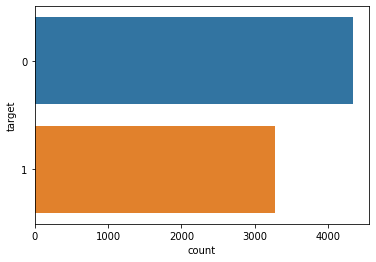

In [ ]:
# Class balance
sns.countplot(y=train.target);

In [ ]:
train_full['target'].value_counts(normalize=1)[0:1] 

0    0.57034
Name: target, dtype: float64

## Keyword analysis

In [ ]:
# Check number of unique keywords
print (train_full.keyword.nunique())

221


Vediamo quali sono le `keywords` più diffuse:

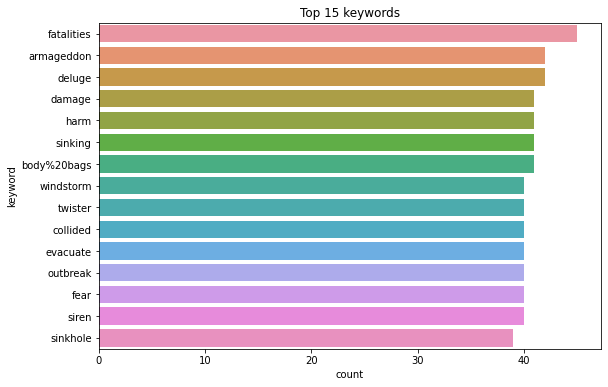

In [ ]:
plt.figure(figsize=(9,6))
sns.countplot(y=train_full.keyword, order = train_full.keyword.value_counts().iloc[:15].index)
plt.title('Top 15 keywords')
plt.show()

Le 10 `keywords` più frequenti nei tweet che riportano un evento catastrofico:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



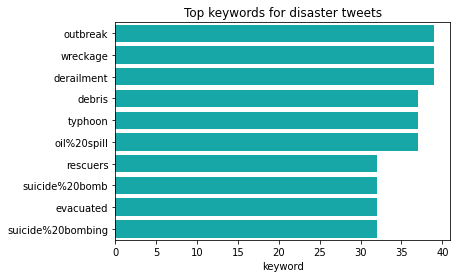

In [ ]:
kw_d = train_full[train_full.target==1].keyword.value_counts().head(10)

sns.barplot(kw_d, kw_d.index, color='c')
plt.title('Top keywords for disaster tweets')
plt.show()


Le 10 `keywords` più frequenti nei tweet che riportano un evento NON catastrofico:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



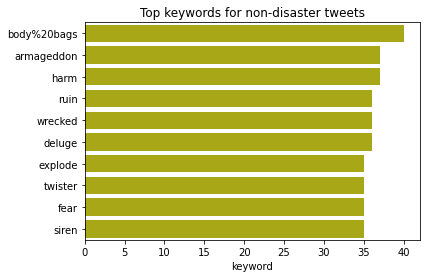

In [ ]:
kw_nd = train_full[train_full.target==0].keyword.value_counts().head(10)

sns.barplot(kw_nd, kw_nd.index, color='y')
plt.title('Top keywords for non-disaster tweets')
plt.show()

Non ci sono parole comuni nei due grafici.


In [ ]:
armageddon_key= train_full[train_full.keyword=='armageddon']
arm0=armageddon_key[armageddon_key.target==0].shape
arm1=armageddon_key[armageddon_key.target==1].shape
perc_arm0=arm0[0]/(arm0[0]+arm1[0])
print('Percentuale di occorrenze della keyword armageddon in tweet NON catastrofici: ',perc_arm0*100,'%')

Percentuale di occorrenze della keyword armageddon in tweet NON catastrofici:  88.09523809523809 %


In [ ]:
explode_key= train_full[train_full.keyword=='explode']
ex0=explode_key[explode_key.target==0].shape
ex1=explode_key[explode_key.target==1].shape
perc_ex0=ex0[0]/(ex0[0]+ex1[0])
print('Percentuale di occorrenze della keyword explode in tweet NON catastrofici: ',perc_ex0*100,'%')

Percentuale di occorrenze della keyword explode in tweet NON catastrofici:  92.10526315789474 %


Andando ad analizzare le 2 parole *armageddon* ed *explode*, che dal punto di vista del significato sembrano stonare rispetto alla loro posizione fra le keyword con maggiori classi negative, ci si è resi conto che non sono keyword su cui fare affidamento in fase di classificazione di nuovi tweet in quanto, seppur parole con un accezione negativa, nel nostro dataset hanno rispettivamente l'88% ed il 92% di occorrenze in tweet non associati a disastri, potrebbe essere dovuto al fatto che le persone tendono ad usare termini più euforici o fuori contesto che vengono poi selezionati come keyword. 
Un esempio è la keyword *explode* usata con la frase 'It's cold and my head wants to explode...'. Anche la parola *armageddon* viene spesso associata videogiochi, film e tag riferiti a username di altri utenti. 


Vediamo quindi le keyword con una % maggiore di comparsa in tweet catastrofici e NON catsatrofici:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



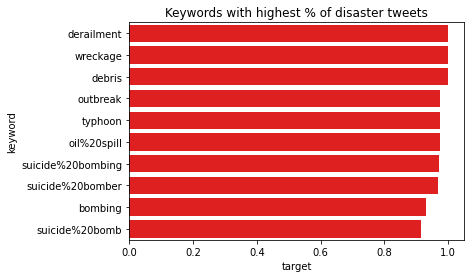

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



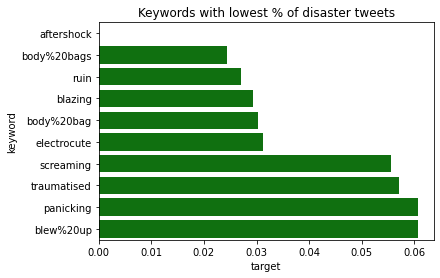

In [ ]:
top_d = train_full.groupby('keyword').mean()['target'].sort_values(ascending=False).head(10)
top_nd = train_full.groupby('keyword').mean()['target'].sort_values().head(10)

sns.barplot(top_d, top_d.index, color='red')
plt.title('Keywords with highest % of disaster tweets')
plt.show()
sns.barplot(top_nd, top_nd.index, color='green')
plt.title('Keywords with lowest % of disaster tweets')
plt.show()

## Location analysis

In [ ]:
# Check number of unique locations
print (train_full.location.nunique())

3341


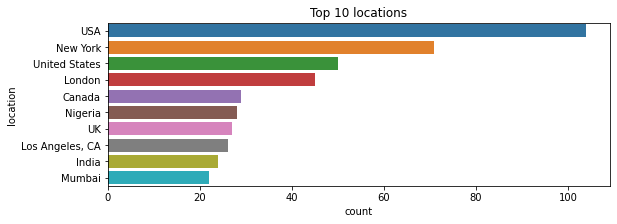

In [ ]:
# Most common locations
plt.figure(figsize=(9,3))
sns.countplot(y=train_full.location, order = train_full.location.value_counts().iloc[:10].index)
plt.title('Top 10 locations')
plt.show()

Possiamo immediatamente notare come l'attributo `location` soffre del problema che non è pulito, potremmo trovare valori diversi come 'USA' e 'Stati Uniti' che indicano lo stesso luogo ma vengono considerati diversi. 

Vediamo i luoghi più frequenti in percentuale dei tweet dove si è verificato un disatro.

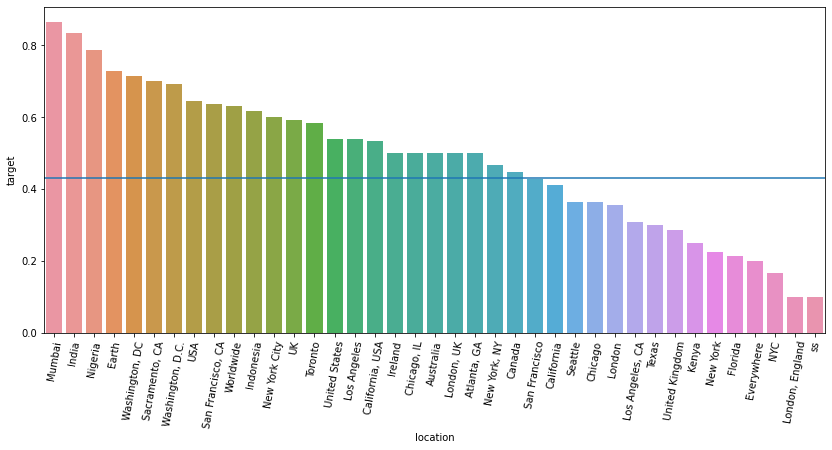

In [ ]:
raw_loc = train_full.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = train_full[train_full.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)
plt.axhline(np.mean(train_full.target))
plt.xticks(rotation=80)
plt.show()

#Feature Engineering

Le tecniche di *feature engineering* riportate di seguito sono possibilità che abbiamo testato nei vari modelli provati. Si noti che non tutte hanno dato i risultati sperati, anzi, ognuna è risultata utile per un gruppo limitato di modelli.

## Duplicate elimination

La rimozione dei duplicati viene effettuata andando ad analizzare solamente gli attributi `text` e `target`

In [ ]:
dupli_sum = train.duplicated().sum()
if(dupli_sum>0):
    print(dupli_sum, " duplicates found\nremoving...")
    train = train.loc[False==train.duplicated(), :]
else:
    print("no duplicates found")
train


92  duplicates found
removing...


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7604,#WorldNews Fallen powerlines on G:link tram: U...,1
7605,on the flip side I'm at Walmart and there is a...,1
7606,Suicide bomber kills 15 in Saudi security site...,1
7608,Two giant cranes holding a bridge collapse int...,1


## Cleaning

In questa fase di cleaning (non sempre eseguita) siamo andati a sostituire alcune parole che potessero essere scritte in forma non contratta o si sono sostituiti dei modi di scrivere appartenenti alla lingua inglese in formato comprensibile a una persona che non conosce certe combinazioni di caratteri.
Inoltre, viene eseguito un *to_lower_case* sull'attributo `text`.
Questa pulizia viene effettuata sia sul training set sia sul test set.

In [ ]:
x = (train['text']
     .str.lower()     
     .str.replace('\x89Ûª|Ûª', "'")
     .str.replace('\n|\x89.|\x9d *', ' ')
     .str.replace('&gt;', ">")
     .str.replace('&lt;', "<")
     .str.replace('&amp;', " and ")
     .str.replace('won\'t', 'will not')
     .str.replace('can\'t', 'cannot')
     .str.replace('i\'m', 'i am')
     .str.replace('ain\'t', 'is not')
     .str.replace('hwy.', 'highway')
     .str.replace('(\w+)\'ll', '\g<1> will')
     .str.replace('(\w+)n\'t', '\g<1> not')
     .str.replace('(\w+)\'ve', '\g<1> have')
     .str.replace('(\w+)\'s', '\g<1> is')
     .str.replace('(\w+)\'re', '\g<1> are')
     .str.replace('(\w+)\'d', '\g<1> would')     
     .str.replace('(\w+)\'m', '\g<1> am')
     .str.replace('<3', 'love')
     .str.replace('w/e', 'whatever')
     .str.replace('w/', 'with')    
     .str.replace('\b', ' ')
     .str.replace('-', ' ')
     .str.replace('  *', ' ')
     .str.replace("couldn't" , "could not")
     .str.replace("couldnt" , "could not")
     .str.replace("didn't" , "did not")
     .str.replace("doesn't" , "does not")
     .str.replace("doesnt" , "does not")
     .str.replace("don't" , "do not")
     .str.replace("hadn't" , "had not")
     .str.replace("hasn't" , "has not")
     .str.replace("haven't" , "have not")
     .str.replace("he'd" , "he would")
     .str.replace("he'll" , "he will")
     .str.replace("he's" , "he is")
     .str.replace("i'd" , "I would")
     .str.replace("i'd" , "I had")
     .str.replace("i'll" , "I will")
     .str.replace("i'm" , "I am")
     .str.replace("isn't" , "is not")
     .str.replace("it's" , "it is")
     .str.replace("it'll","it will")
     .str.replace("i've" , "I have")
     .str.replace("let's" , "let us")
     .str.replace("mightn't" , "might not")
     .str.replace("mustn't" , "must not")
     .str.replace("shan't" , "shall not")
     .str.replace("she'd" , "she would")
     .str.replace("she'll" , "she will")
     .str.replace("she's" , "she is")
     .str.replace("shouldn't" , "should not")
     .str.replace("shouldnt" , "should not")
     .str.replace("that's" , "that is")
     .str.replace("there's" , "there is")
     .str.replace("theres" , "there is")
     .str.replace("they'd" , "they would")
     .str.replace("they'll" , "they will")
     .str.replace("they're" , "they are")
     .str.replace("theyre",  "they are")
     .str.replace("they've" , "they have")
     .str.replace("we'd" , "we would")
     .str.replace("we're" , "we are")
     .str.replace("weren't" , "were not")
     .str.replace("we've" , "we have")
     .str.replace("what'll" , "what will")
     .str.replace("what're" , "what are")
     .str.replace("what's" , "what is")
     .str.replace("what've" , "what have")
     .str.replace("where's" , "where is")
     .str.replace("who'd" , "who would")
     .str.replace("who'll" , "who will")
     .str.replace("who're" , "who are")
     .str.replace("who's" , "who is")
     .str.replace("who've" , "who have")
     .str.replace("won't" , "will not")
     .str.replace("wouldn't" , "would not")
     .str.replace("you'd" , "you would")
     .str.replace("you'll" , "you will")
     .str.replace("you're" , "you are")
     .str.replace("you've" , "you have")
     .str.replace("'re", " are")
     .str.replace("wasn't", "was not")
     .str.replace("we'll"," will")
     .str.replace("didn't", "did not")
     .str.strip()
     .to_numpy()
    )

train['text']=x
#train_full['text']=x
train_full.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Cleaning sul test set

In [ ]:
y = (test_full['text']
     .str.lower()     
     .str.replace('\x89Ûª|Ûª', "'")
     .str.replace('\n|\x89.|\x9d *', ' ')
     .str.replace('&gt;', ">")
     .str.replace('&lt;', "<")
     .str.replace('&amp;', " and ")
     .str.replace('won\'t', 'will not')
     .str.replace('can\'t', 'cannot')
     .str.replace('i\'m', 'i am')
     .str.replace('ain\'t', 'is not')
     .str.replace('hwy.', 'highway')
     .str.replace('(\w+)\'ll', '\g<1> will')
     .str.replace('(\w+)n\'t', '\g<1> not')
     .str.replace('(\w+)\'ve', '\g<1> have')
     .str.replace('(\w+)\'s', '\g<1> is')
     .str.replace('(\w+)\'re', '\g<1> are')
     .str.replace('(\w+)\'d', '\g<1> would')     
     .str.replace('(\w+)\'m', '\g<1> am')
     .str.replace('<3', 'love')
     .str.replace('w/e', 'whatever')
     .str.replace('w/', 'with')    
     .str.replace('\b', ' ')
     .str.replace('-', ' ')
     .str.replace('  *', ' ')
     .str.replace("couldn't" , "could not")
     .str.replace("couldnt" , "could not")
     .str.replace("didn't" , "did not")
     .str.replace("doesn't" , "does not")
     .str.replace("doesnt" , "does not")
     .str.replace("don't" , "do not")
     .str.replace("hadn't" , "had not")
     .str.replace("hasn't" , "has not")
     .str.replace("haven't" , "have not")
     .str.replace("he'd" , "he would")
     .str.replace("he'll" , "he will")
     .str.replace("he's" , "he is")
     .str.replace("i'd" , "I would")
     .str.replace("i'd" , "I had")
     .str.replace("i'll" , "I will")
     .str.replace("i'm" , "I am")
     .str.replace("isn't" , "is not")
     .str.replace("it's" , "it is")
     .str.replace("it'll","it will")
     .str.replace("i've" , "I have")
     .str.replace("let's" , "let us")
     .str.replace("mightn't" , "might not")
     .str.replace("mustn't" , "must not")
     .str.replace("shan't" , "shall not")
     .str.replace("she'd" , "she would")
     .str.replace("she'll" , "she will")
     .str.replace("she's" , "she is")
     .str.replace("shouldn't" , "should not")
     .str.replace("shouldnt" , "should not")
     .str.replace("that's" , "that is")
     .str.replace("there's" , "there is")
     .str.replace("theres" , "there is")
     .str.replace("they'd" , "they would")
     .str.replace("they'll" , "they will")
     .str.replace("they're" , "they are")
     .str.replace("theyre",  "they are")
     .str.replace("they've" , "they have")
     .str.replace("we'd" , "we would")
     .str.replace("we're" , "we are")
     .str.replace("weren't" , "were not")
     .str.replace("we've" , "we have")
     .str.replace("what'll" , "what will")
     .str.replace("what're" , "what are")
     .str.replace("what's" , "what is")
     .str.replace("what've" , "what have")
     .str.replace("where's" , "where is")
     .str.replace("who'd" , "who would")
     .str.replace("who'll" , "who will")
     .str.replace("who're" , "who are")
     .str.replace("who's" , "who is")
     .str.replace("who've" , "who have")
     .str.replace("won't" , "will not")
     .str.replace("wouldn't" , "would not")
     .str.replace("you'd" , "you would")
     .str.replace("you'll" , "you will")
     .str.replace("you're" , "you are")
     .str.replace("you've" , "you have")
     .str.replace("'re", " are")
     .str.replace("wasn't", "was not")
     .str.replace("we'll"," will")
     .str.replace("didn't", "did not")
     .str.strip()
     .to_numpy()
    )

test=y
test_full['text']=y
test_full.head()

,id,keyword,location,text
0,0,NaN,NaN,just happened a terrible car crash
1,2,NaN,NaN,"heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,apocalypse lighting. #spokane #wildfires
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan


# Linear Classifier

Il primo modello che viene implementato per la risoluzione del problema è un **classificatore lineare** a due dimensioni. Vengono riportati i dataset di training e testing.

In [ ]:
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

train_df = train
test_df = pd.read_csv(TEST_PATH)

## Tokenization

I file di testo sono una serie di parole ordinate e per essere date in pasto agli algoritmi di ML è necessario convertirli in vettori numerici. Per questi primi modelli viene usata la tecnica *bag of words*, ovvero ogni file viene diviso usando gli spazi come caratteri separatori. Ogni parola costituisce un token. 
Si conta poi quante volte una parola compare all'interno di ogni tweet e le viene assegnato un ID.
Viene così creato un dizionario all'interno del quale ogni parola è univoca e corrisponde ad una feature.

*Scikit-learn* permette di usare *CountVectorizer* che si occupa di svolgere questo processo ad alto livello.

In [ ]:
count_vectorizer = feature_extraction.text.CountVectorizer()

train_vectors = count_vectorizer.fit_transform(train_df["text"])
test_vectors = count_vectorizer.transform(test_df["text"])


Dopo aver eseguito il codice *train_vectors* sarà una matrice di dimensione [n_samples, n_features].

Si noti che quando viene eseguita la tokenization sul testset non si usa *.fit_transform()*, ma semplicemente *.transform()* per fare in modo che i token ottenuti dal vettore di training siano i soli presenti anche nel vettore di test. Infatti, si vuole che testset e trainset usino lo stesso dizionario e quindi lo stesso insieme di token. 

## Model

In [ ]:
clf = linear_model.RidgeClassifier()

In [ ]:
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=3, scoring="f1")
scores

array([0.58525853, 0.55963764, 0.64529058])

In [ ]:
clf.fit(train_vectors, train_df["target"])

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

## Testing and submission

In [ ]:
sample_submission = pd.read_csv(SUBMISSION_PATH)
sample_submission["target"] = clf.predict(test_vectors)

In [ ]:
sample_submission.to_csv("submissionLinear.csv", index=False)
sample_submission

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


Il Linear Classifier ha ottenuto uno score di **0.78057** con l'utilizzo di quanto riportato nella sezione *Cleaning*, mentre senza il punteggio si è abbassato a **0.78026**. 
Si può dire quindi che tale operazione risulta trascurabile per questo modello.

# Naive Bayes (NBClassifier)

Il Naive Bayes è un algoritmo classificatore basato sul teorema di Bayes. Per usare il classificatore bayesano occorre conoscere o stimare le probabilità a priori e condizionali del problema.
E' detto "naive" perché le ipotesi di partenza sono molto semplificate. In particolar modo, si considerano indipendenti tra loro le varie features del modello.

## Extracting features from text-file

Nel modello precedente è stato usato TF (Term Frequency) che conta solo il numero di parole nel documento. Il problema sta nel fatto che così viene dato più peso ai tweet lunghi poichè contenenti molte parole.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

train_nb = train
test_nb = pd.read_csv(TEST_PATH)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_nb["text"])
#X_train_counts = count_vect.fit_transform(train_nb["cleaned_text"])
X_train_counts.shape

(7521, 21646)

Da questo modello viene usato, invece, TF-IDF (Term Frequency times inverse document frequency) che permette di bilanciare i pesi riducendo anche quello delle parole più comuni (the, is, an, ...).

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(7521, 21646)

L'ultima riga fornisce in output la dimensione della matrice risultante.

## Model training

Il modello viene creato usando una pipeline che permette di scrivere meno codice e riassume quanto fatto in precedenza inserendolo nella creazione del modello.

Esiste la possibilità di eliminare le *stop words*, ovvero le parole più comuni, ma di scarso valore tramite una semplice opzione da esplicitare in *CountVectorizer()*. Si noti però che non sempre tali parole sono inutili per il problema e quindi si potrebbe avere un detecremento delle prestazioni. Queste valutazioni verranno riprese in seguito.

In [ ]:
# Training Naive Bayes (NB) classifier on training data.
from sklearn.naive_bayes import MultinomialNB

# Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:
# The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary but will be used later.
# We will be using the 'text_clf' going forward.
from sklearn.pipeline import Pipeline

# Removing stop words: (the, then etc) from the data. 
# You should do this only when stop words are not useful for the underlying problem. 
# In most of the text classification problems, this is indeed not useful. 
# Let’s see if removing stop words increases the accuracy adding the parameter stop_words='english' in CountVectorizer()
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

#text_clf = text_clf.fit(train_nb.cleaned_text, train_nb.target)
text_clf = text_clf.fit(train_nb.text, train_nb.target)

## Testing and submission

In [ ]:
# Performance of NB Classifier
import numpy as np
predicted = text_clf.predict(test_nb.text)

In [ ]:
sample_submission = pd.read_csv(SUBMISSION_PATH)
sample_submission["target"] = predicted
sample_submission.to_csv("submissionNBClassifier.csv", index=False)
sample_submission

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


Il modello con *NBClassifier* ha ottenuto uno score di **0.79344** in fase di testing, risultando essere migliore del classificatore lineare. Inoltre implementando la rimozione delle stop words si è riscontrato un miglioramento delle prestazioni minimo, ma comunque significativo (**0.79619**). Anche qui tutte le operazioni di *Cleaning* sono risultate superflue.

# SVM

Questo modello viene costruito in modo molto simile al precedente usando una pipeline. 
Viene usato il classificatore lineare *SGDClassifier* che di default lavora con SVM e implementa una discesa del gradiente stocastica (SGD).
I parametri utilizzati sono:


*   `loss` definisce la loss function utilizzata. di default è SVM;
*   `penalty` definisce il termine di regolarizzazione;
*   `alpha` definisce la costante per cui il termine di regolarizzazione viene moltiplicato
*   `max_iter` definisce il numero massimo di passi (epoche) sul training set;
*   `random_state` usato per lo shuffle dei dati



In [ ]:
# Training Support Vector Machines - SVM and calculating its performance

from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=15, random_state=42))])

text_clf_svm = text_clf_svm.fit(train_nb.text, train_nb.target)
predicted_svm = text_clf_svm.predict(test_nb.text)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



In [ ]:
sample_submission = pd.read_csv(SUBMISSION_PATH)
sample_submission["target"] = predicted_svm
sample_submission.to_csv("submissionSVM.csv", index=False)
sample_submission

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,0
3259,10865,0
3260,10868,1
3261,10874,1


Il classificatore SVM *SGDClassifier* ha totalizzato uno score di **0.77076** in fase di testing, collocandosi alle spalle del classificatore lineare come prestazioni. 
Nessuna modifica ai parametri o alle operazioni di preprocessing hanno portato a miglioramenti nelle prestazioni di questo modello. La nostra ipotesi è che potrebbe essere necessario usare un classificatore diverso per implementare SVM.

#Grid Search

Scikit fornisce il tool *GridSearchCV* per effettuare una ricerca golosa e permettere di settare manualmente alcuni parametri di diversi classificatori in modo da cercare velocemente soluzioni sub-ottimali.

Di seguito viene creata una lista di parametri per cui vogliamo eseguire del *performance tuning*:


*   `vect__ngram_range`
*   `tfidf__use_idf`
*   `clf__alpha`



In [ ]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1, 0.8, 0.7, 0.3, 1e-1, 1e-2, 1e-3)}

Di seguito viene creata un'istanza di GridSearch fornendo l'NBClassifier usato in precedenza (è possibile fare lo stesso anche per il classificatore SVM usando i parametri adeguati). Il parametro `n_jobs=-1` indica alla macchina di usare più core.

In [ ]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(train_nb.text, train_nb.target)

E' possibile osservare il migliore score ottenuto dalle varie combinazioni di parametri...

In [ ]:
gs_clf.best_score_

0.7191868417332297

...e anche qual è la combinazione che ha dato i risultati ottimali.

In [ ]:
gs_clf.best_params_

{'clf__alpha': 0.8, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 3)}

In [ ]:
sample_submission = pd.read_csv(SUBMISSION_PATH)
sample_submission["target"] = gs_clf.predict(test_nb.text)
sample_submission.to_csv("submissionGridNB.csv", index=False)
sample_submission

,id,target
0,0,0
1,2,0
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


Il modello Grid Search applicato al *NBClassifier* ha ottenuto uno score di **0.79436** in fase di testing risultando essere allineato al punteggio ottenuto in precedenza dal classificatore base. Ciò ci fa capire come i parametri con cui era stato impostato il classificatore fossero già quelli ottimali per il nostro problema. Un'altra possibilità è che la soluzione ottimale sia al di fuori di quelle provate nella nostra ricerca.

# Random Forest

Il prossimo modello che viene testato è relativo a **Random Forest** ed **Extra Trees**. Come prima cosa, anche in questo caso, viene riportato il dataset.

In [ ]:
train_rf = train_full
test_rf = test_full

Per questo modello vengono eseguite delle operazioni di feature engineering simili agli altri, ma leggermente diversi per necessità del modello stesso.

In [ ]:
#Removing Duplicated rows
train_rf.drop_duplicates(subset=['keyword', 'text', 'target'],keep='first', inplace=True)

#Replacing null with 'null'
train_rf['location'].fillna('null9999', inplace=True) 
train_rf['keyword'].fillna('null9999', inplace=True)
test_rf['location'].fillna('null9999', inplace=True) 
test_rf['keyword'].fillna('null9999', inplace=True)

Al termine, il dataset si presenta come segue:

In [ ]:
train_rf.head()

,id,keyword,location,text,target
0,1,null9999,null9999,Our Deeds are the Reason of this #earthquake M...,1
1,4,null9999,null9999,Forest fire near La Ronge Sask. Canada,1
2,5,null9999,null9999,All residents asked to 'shelter in place' are ...,1
3,6,null9999,null9999,"13,000 people receive #wildfires evacuation or...",1
4,7,null9999,null9999,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test_rf.head()

,id,keyword,location,text
0,0,null9999,null9999,just happened a terrible car crash
1,2,null9999,null9999,"heard about #earthquake is different cities, s..."
2,3,null9999,null9999,"there is a forest fire at spot pond, geese are..."
3,9,null9999,null9999,apocalypse lighting. #spokane #wildfires
4,11,null9999,null9999,typhoon soudelor kills 28 in china and taiwan


Decidiamo di eseguire dei test per verificare l'accuratezza del classificatore e per fare questo dividiamo il training set in modo da poter calcolare lo score.

In [ ]:
#Preparing data
X = train_rf['text']
y = train_rf['target']
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42)

In [ ]:
X_train

3093    Photo: weallheartonedirection: I wouldnÛªt le...
2664    @channelstv:That's why terrorism is not d war ...
7221    Incredulous at continued outcry of welfare bei...
3305    So all the store's fire alarms went off today ...
1012    Woke up to Drake body bagging Meek again!! Mee...
                              ...                        
3702    cause i know every man has a fear of a strong-...
6428    After a suicide bombing in SuruÌ¤ that killed ...
6854    Photo: lavenderpoetrycafe: The Forgotten Histo...
3427    what if i want to fuck the duck until explode....
5659    Last Chance Animal Rescue has 3 new posts. htt...
Name: text, Length: 5655, dtype: object

In [ ]:
X_test

1794    If you sit and rant on snapchat to your appare...
6746    Lily Xo is a sexy cowgirl out in the sticks ht...
3892    Picking up flattened hay men (@ Masonite in Wa...
1961    @roughdeal1 ante hudhud cyclone Chandrababu Va...
3265    Why are you engulfed by low self-image? Take t...
                              ...                        
6735    Thunderstorm in Helsinki\n#thunder #lightning ...
7148    Zeal is a volcano the peak of which the grass ...
1029    BREAKING: Fairfax County firefighter placed on...
2331    EPA begins demolition of homes in toxic area #...
4088    @modnao23 the hail is ruining everything. Plus...
Name: text, Length: 1886, dtype: object

In [ ]:
y_train

3093    0
2664    1
7221    1
3305    1
1012    0
       ..
3702    0
6428    1
6854    1
3427    0
5659    0
Name: target, Length: 5655, dtype: int64

In [ ]:
y_test

1794    0
6746    0
3892    0
1961    1
3265    0
       ..
6735    1
7148    1
1029    0
2331    1
4088    1
Name: target, Length: 1886, dtype: int64

## Tokenization

In [ ]:
#Tokenization
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## Model

Per creare il modello vengono provati diversi classificatori. Inizialmente si usa *RandomForestClassifier* con i parametri di default.

In [ ]:
#Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_vec,y_train)
print("Cross Val Score: ",cross_val_score(rf,X_train_vec,y_train,cv=5).mean())
print("Train Score: ", round(rf.score(X_train_vec,y_train),4))
print("Validation Score: ", round(rf.score(X_test_vec,y_test),4))

Cross Val Score:  0.7793103448275862
Train Score:  0.9979
Validation Score:  0.7826


In seguito si prova *ExtraTreesClassifier* sempre con parametri di default.

In [ ]:
#Extra Trees
et = ExtraTreesClassifier(random_state=42)
et.fit(X_train_vec,y_train)
print("Cross Val Score: ",cross_val_score(rf,X_train_vec,y_train,cv=5).mean())
print("Train Score: ", round(et.score(X_train_vec,y_train),4))
print("Validation Score: ", round(et.score(X_test_vec,y_test),4))

Cross Val Score:  0.7793103448275862
Train Score:  0.9979
Validation Score:  0.79


Si passa poi ad una tecnica leggermente più complessa basata su bagging:

In [ ]:
#Bagging Classifier
bagged = BaggingClassifier(base_estimator=ExtraTreesClassifier(random_state=42))
bagged.fit(X_train_vec,y_train)
print("Cross Val Score: ",cross_val_score(bagged,X_train_vec,y_train,cv=5).mean())
print("Train Score: ",bagged.score(X_train_vec,y_train))
print("Validation Score: ",bagged.score(X_test_vec,y_test))

Cross Val Score:  0.7913351016799293
Train Score:  0.9909814323607427
Validation Score:  0.7926829268292683


## Parameters tuning

I modelli basati su Extra Trees e Random Forest sono chiaramente in overfitting, quindi tramite tuning dei parametri proviamo a cercare soluzioni migliori. In particolare, potrebbe essere utile inserire un limite di profondità nella ricerca.

Di seguito è riportato il codice per il tuning di Random Forest, ma un procedimento simile può essere applicato su Extra Trees.

In [ ]:
parameters = {'criterion': ('gini', 'entropy'), 'max_depth': (100, 120, 150), 'max_features': ('auto', 0.8, 0.4)}

In [ ]:
gs_rf = GridSearchCV(rf, parameters, n_jobs=-1)
gs_rf = gs_rf.fit(X_train_vec,y_train)

KeyboardInterrupt: ignored

In [ ]:
gs_rf.best_params_

In [ ]:
#Running Random forest with optimal HyperParameters
rf = RandomForestClassifier(random_state=42,criterion='entropy',max_features='auto',max_depth=120)
rf.fit(X_train_vec,y_train)
print("Cross Val Score: ",cross_val_score(rf,X_train_vec,y_train,cv=5).mean())
print("Train Score: ", round(rf.score(X_train_vec,y_train),4))
print("Test Score: ", round(rf.score(X_test_vec,y_test),4))

Una volta scelti i modelli più promettenti eseguiamo l'addestramento sull'intero training set 

In [ ]:
#Final model
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train_rf["text"])
test_vectors = count_vectorizer.transform(test_rf["text"])
#Optimal Random Forest
rff = RandomForestClassifier(random_state=42,criterion='entropy',max_features='auto',max_depth=120)
rff.fit(train_vectors, train_rf["target"])
#Extra Trees
etf = ExtraTreesClassifier(random_state=42)
etf.fit(train_vectors, train_rf["target"])

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

In [ ]:
#Bagging
baggedf = BaggingClassifier(base_estimator=ExtraTreesClassifier(random_state=42))
baggedf.fit(train_vectors, train_rf["target"])

##Feature Importance

Di seguito mostriamo le informazioni relative alla feature importance ricavate dal modello Random Forest. Questa è una tecnica poco utile in ambito NLP, perchè il dataframe va a formarsi di tutte le parole presenti nel dizionario che andranno poi a costituire le nuove features utilizzate. Avendo molte parole l'importanza di ognuna è molto bassa e quindi poco significativa.
Inoltre, da queste informazioni non si può ricavare nessuno spunto per fare ulteriore feature engineering.

In [ ]:
train_vectors.todense()
test_vectors.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
new_train_df = pd.DataFrame()
new_test_df = pd.DataFrame()

for i, col in enumerate(count_vectorizer.get_feature_names()):
    new_train_df[col] = pd.Series(train_vectors[:, i].toarray().ravel())
    
for i, col in enumerate(count_vectorizer.get_feature_names()):
    new_test_df[col] = pd.Series(test_vectors[:, i].toarray().ravel())

In [ ]:
importances = rff.feature_importances_
std = np.std([tree.feature_importances_ for tree in rff.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [ ]:
# Print the feature ranking
print("Feature ranking:")

for f in range(0,20): # X_train_vec.shape[1]
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]), new_train_df.iloc[:,indices[f]].name)

Feature ranking:
1. feature 9304 (0.023290) http
2. feature 4517 (0.016962) co
3. feature 9718 (0.010829) in
4. feature 21285 (0.009060) you
5. feature 9078 (0.007729) hiroshima
6. feature 3797 (0.007587) california
7. feature 12929 (0.007292) my
8. feature 10830 (0.006280) killed
9. feature 7439 (0.005772) fire
10. feature 7453 (0.005233) fires
11. feature 20606 (0.004365) wildfire
12. feature 13681 (0.004339) of
13. feature 18669 (0.004216) the
14. feature 18098 (0.003855) suicide
15. feature 17936 (0.003617) storm
16. feature 3300 (0.003591) bombing
17. feature 19446 (0.003487) typhoon
18. feature 12362 (0.003424) mh370
19. feature 18971 (0.003382) to
20. feature 20330 (0.003372) warning


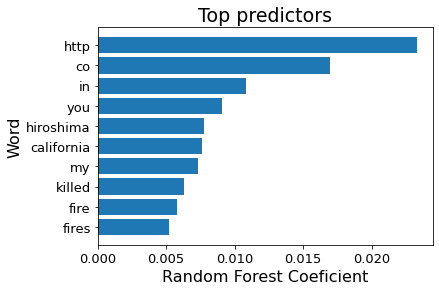

<Figure size 936x936 with 0 Axes>

In [ ]:
# Make dataset
number_features_print = 10
height = [importances[indices[i]] for i in range(0,number_features_print)]
bars = [new_train_df.iloc[:,indices[x]].name for x in range(0,number_features_print)]

height.reverse()
bars.reverse()

y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)
plt.title('Top predictors',fontsize=19)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.ylabel('Word', fontsize = 16)
plt.xlabel('Random Forest Coeficient', fontsize = 16)
plt.figure(figsize=(13, 13))

# Show graphic
plt.show();

## Testing and submission

In [ ]:
#Optimal Random Forest
sample_submission = pd.read_csv(SUBMISSION_PATH)
sample_submission["target"] = rff.predict(test_vectors)
sample_submission.to_csv("submissionRF2.csv", index=False)

In [ ]:
#Extra Trees
sample_submission = pd.read_csv(SUBMISSION_PATH)
sample_submission["target"] = etf.predict(test_vectors)
sample_submission.to_csv("submissionET.csv", index=False)

In [ ]:
#Bagging
sample_submission = pd.read_csv(SUBMISSION_PATH)
sample_submission["target"] = baggedf.predict(test_vectors)
sample_submission.to_csv("submissionBagging.csv", index=False)

Il Modello basato su Random forest ha ottenuto uno score di **0.78577**, mentre Extra Trees **0.79834**. Il bagging sugli Extra trees ha generato uno score di **0.79436**, quindi non ha dato particolari benefici l'utilizzo di questa tecnica.

# Neural Network with BERT Classifier 

BERT e altre architetture di codificatori Transformer hanno avuto un enorme successo in una varietà di compiti in NLP (elaborazione del linguaggio naturale). Calcolano rappresentazioni nello spazio vettoriale del linguaggio naturale che sono adatte per l'uso in modelli di deep learning. La famiglia di modelli BERT utilizza l'architettura dell'encoder Transformer per elaborare ogni token di testo di input nel contesto completo di tutti i token prima e dopo, da cui il nome: Rappresentazioni dell'Encoder Bidirezionale da Transformers.

I modelli BERT sono generalmente pre-addestrati su un ampio corpus di testo, quindi perfezionati per compiti specifici.

## Tokenization



Gli input di testo devono essere trasformati in ID token numerici e organizzati in diversi tensori prima di essere immessi in BERT. TensorFlow Hub fornisce un modello di pre-elaborazione corrispondente per ciascuno dei modelli BERT.

In [ ]:
Text_train = train["text"].values
#Text_train = train.cleaned_text.values
Target_train = train["target"].values


Per il nostro scopo decidiamo di usare uno dei modelli base di BERT, *BERT_base-uncased*.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
lens = []


for text in Text_train:
    encoded_dict = tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='pt')
    lens.append(encoded_dict['input_ids'].size()[1])



Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

text length mean:  32.41005185480654
text length median:  32.0
text length standard deviation:  11.871712660989116


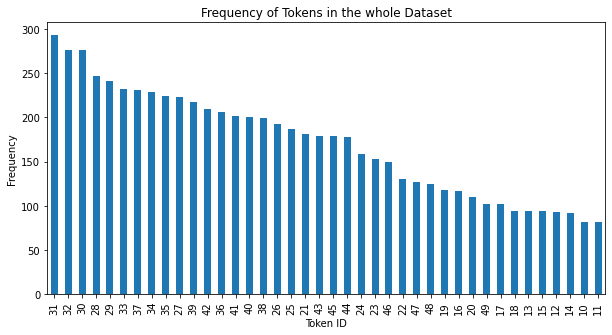

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Frequency of Tokens in the whole Dataset")
ax.set_xlabel("Token ID")
ax.set_ylabel("Frequency")
pd.Series(lens).value_counts().head(40).plot(kind="bar");
print("text length mean: ", np.array(lens).mean())
print("text length median: ", np.median(lens))
print("text length standard deviation: ", np.array(lens).std())

Il parametro `sequence_length` definisce la lunghezza di ogni sequenza di token e impostarlo correttamente è molto importante. Abbia osservato che la lunghezza media dei tweet si attesta sulle 32 parole (quindi 32 token) con una deviazione standard di circa 12. Di conseguenza una `sequence_length=64` potrebbe essere adeguata, poichè usando `sequence_length=32` si perderebbero delle informazioni.
Si è comunque deciso di testare entrambe le possibilità.



In [ ]:
sequence_length = 64
# Text_train_tokens[i] := sequence of sequence_length many tokens that represent text_{i}
Text_train_tokens = []
train_attention_masks = []

for text in Text_train:
    encoded_dict = tokenizer.encode_plus(text,
                                         add_special_tokens=True, # special tokens for BERT
                                         max_length=sequence_length,
                                         padding="max_length",
                                         return_tensors='pt', # pytorch tensor format
                                         truncation=True)
    Text_train_tokens.append(encoded_dict['input_ids'])
    train_attention_masks.append(encoded_dict["attention_mask"])

# pytorch expects tensors
Text_train_tokens = torch.cat(Text_train_tokens, dim=0) # concat into one tensor
train_attention_masks = torch.cat(train_attention_masks, dim=0)
Target_train = torch.tensor(Target_train)

A questo punto è stato creato l'*encoded_dictionary* e di seguito si può visualizzare come si presentano i tensori in seguito alla tokenization.
Si noti che:

*   Il token iniziale è un carattere speciale [101] che indica sempre l'inizio della sequenza;
*   Al termine della sequenza viene inserito un carattere di terminazione [102];
*   La sequenza viene completata con dei token a zero fino a raggiungere la dimensione definita da `sequence_length`.



In [ ]:
# tokenization of the first three observations in the training set
# zero-padding is added
print('Original:\n', Text_train[0])
print('Tokenization:\n', Text_train_tokens[0])
print('Original:\n', Text_train[1])
print('Tokenization:\n', Text_train_tokens[1])
print('Original:\n', Text_train[2])
print('Tokenization:\n', Text_train_tokens[2])

Original:
 our deeds are the reason of this #earthquake may allah forgive us all
Tokenization:
 tensor([  101,  2256, 15616,  2024,  1996,  3114,  1997,  2023,  1001,  8372,
         2089, 16455,  9641,  2149,  2035,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
Original:
 forest fire near la ronge sask. canada
Tokenization:
 tensor([  101,  3224,  2543,  2379,  2474,  6902,  3351, 21871,  2243,  1012,
         2710,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0, 

## Dataloader

A questo punto vengono usati dei *Dataloaders* per definire delle batches dai dati. Decidiamo di provare `batch_size = 16` inizialmente, ovvero ogni batch contenente 16 tweet.
In seguito ci siamo accorti che usando `batch_size = 32` si ottenevano prestazioni migliori.

In [ ]:
batch_size = 32
# split into training and validation data
dataset = TensorDataset(Text_train_tokens.to(device), 
                        Target_train.float().to(device), 
                        train_attention_masks.to(device))
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_set, 
                              sampler=RandomSampler(train_set), 
                              batch_size=batch_size)

validation_dataloader = DataLoader(val_set, 
                                   sampler=RandomSampler(val_set), 
                                   batch_size=batch_size)

 Si è deciso di dividere il dataset in due parti, una per il training e una per la validazione. L'80% del dataset è stato usato come training set e il restante 20% come validation. In seguito si sono provate anche distribuzioni diverse ottenendo risultati peggiori. 
 Per la divisione viene usato un `random_split()`.

Un Dataloader è usato per creare le batches per il training, l'altro per la fase di validazione. Ogni sottogruppo viene creato campionando senza reinserimento.

In sostanza viene eseguito il seguente procedimento:

1.   Creazione di training set e validation set;
2.   Creazione di un Dataloader per ognuno dei set e definizione delle regole di campionamento e della dimensione delle batch.

In [ ]:
example_batch = next(iter(train_dataloader))

print("what is drawn from our dataloader? ", type(example_batch))
print("\nfirst entry: ", example_batch[0].size(), type(example_batch[0]), example_batch[0].dtype)
print("\nsecond entry: ", example_batch[1].size(), type(example_batch[1]), example_batch[1].dtype)

what is drawn from our dataloader?  <class 'list'>

first entry:  torch.Size([32, 64]) <class 'torch.Tensor'> torch.int64

second entry:  torch.Size([32]) <class 'torch.Tensor'> torch.float32


## Model creation

Nella creazione del modello BERT si fa uso di una rete neurale già preallenata del tipo *bert-base-uncased* con le seguenti caratteristiche:


*   12 livelli
*   768 neuroni nello strato nascosto
*   110M parametri
*   allenata su testi inglesi in formato minuscolo







In [ ]:
bert = BertModel.from_pretrained("bert-base-uncased")
bert.to(device)

batch_features = example_batch[0].to(device)
bert_output = bert(input_ids=batch_features) 
print("bert output: ", type(bert_output), len(bert_output))
print("first entry: ", type(bert_output[0]), bert_output[0].size())
print("second entry: ", type(bert_output[1]), bert_output[1].size())

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert output:  <class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions'> 2
first entry:  <class 'torch.Tensor'> torch.Size([32, 64, 768])
second entry:  <class 'torch.Tensor'> torch.Size([32, 768])


Creazione della classe BertClassifier con i relativi attributi: 

* `bert`: modello bert-base-uncased
* `dropout`: funzione per diminuire il rischio di overfitting
* `linear`: applica una trasformazione lineare del tipo : y = xA'+b
* `batchnorm`: applica la normalizzazione di una matrice o tensore
* `sigmoid`: funzione di attivazione adottata


Il metodo *forward()* serve a regolare la parte feed forward.

Sono presenti i metodi di *freeze()* ed *unfreeze()* per consentire effettivamente di decidere quali livelli specifici della rete neurale si  desidera addestrare in una determinata epoca.

*freeze()* imposterà tutti i livelli tranne l'ultimo come non addestrabili, questo per impedire che i pesi dei livelli più generici di rete neurale vengano modificati durante la backward propagation, questo blocco serve a ridurre la quantità di calcolo nel passaggio all'indietro e per ridurre il tempo di allenamento. 

*unfreeze()* sbloccherà tutti i livelli del modello, quindi si andrà ad allenare sia i primi livelli sia l'ultimo e si riprenderà con il calcolo del gradiente e la propagazione all'indietro dei pesi.

Questa è una tecnica comune in NLP o Computer Vision, quando si lavora su piccoli set di dati in quanto di solito riduce le possibilità che il modello vada in overfitting.


In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, linear_size):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout1 = nn.Dropout()
        self.linear1 = nn.Linear(in_features=768, out_features=linear_size)
        #self.dropout2 = nn.Dropout(p=0.8)
        self.dropout2 = nn.Dropout(p=0.25)
        self.batch_norm1 = nn.BatchNorm1d(num_features=linear_size)
        self.linear2 = nn.Linear(in_features=linear_size, out_features=1)
        self.batch_norm2 = nn.BatchNorm1d(num_features=1)
        self.sigmoid = nn.Sigmoid() # activation function to obtain probabilities
    
    def forward(self, tokens, attention_mask):
        bert_output = self.bert(input_ids=tokens, attention_mask=attention_mask)
        x = self.dropout1(bert_output[1])
        x = self.linear1(x)
        x = self.dropout2(x)
        x = self.batch_norm1(x)
        x = self.linear2(x)
        x = self.batch_norm2(x)
        proba = self.sigmoid(x)
        return proba
      
    def freeze_bert(self):
        for param in self.bert.named_parameters():
            param[1].requires_grad=False
            
    def unfreeze_bert(self):
        for param in self.bert.named_parameters():
            param[1].requires_grad=True

## Training and validation

Il metodo *eval()* delle prestazioni viene calcolato secondo 2 metriche prese da sklearn (accuracy_score e f1_score) calcolate andando a vedere le differenze fra i valori predetti del batch e l'effettivo valore reale di classe del batch.

Il metodo di train applica un pre ottimizzatore (adamW) che richiede in ingresso i parametri del modello, il learning rate (lr) e un termine di depolarizzazione (eps).
Come loss function viene usata la BCEloss.
Lo scheduler viene impostato in maniera dinamica in modo tale da poter adattare il learning rate nel caso ci fossero dei plateau.

Per ogni epoca vengono stampate delle informazioni sommarie, si cambia la modalità tra freeze e d unfreeze a seconda del loro numero, per poi passare all'applicazione del gradiente effettivo con l'allenamento della rete.

Una volta finita la fase di allenamento si passa alla fase di validazione ed in seguito si calcolano le metriche di accuratezza.


In [ ]:
def eval(y_batch, probas):
    preds_batch_np = np.round(probas.cpu().detach().numpy())
    y_batch_np = y_batch.cpu().detach().numpy()
    acc = accuracy_score(y_true=y_batch_np, y_pred=preds_batch_np)
    f1 = f1_score(y_true=y_batch_np, y_pred=preds_batch_np, average='weighted')
    return acc, f1

    
def train(model, epochs, freeze_epochs, unfreeze_epochs):
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    #optimizer = AdamW(model.parameters(), lr=1e-5, eps=5e-6)
    loss_func = nn.BCELoss()
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=2)
    history = []
    best_acc = 0
    for epoch in range(1, epochs + 1):
        print("=== Epoch: ", epoch, " / ", epochs, " ===")
        print("LR:", optimizer.state_dict()["param_groups"][0]["lr"])
        if epoch in freeze_epochs:  # stop training bert
            print("Freeze BERT")
            model.freeze_bert()

        if epoch in unfreeze_epochs:  # train bert
            print("Unfreeze BERT")
            model.unfreeze_bert()
        
        # ===== train =====
        model.train()  # train mode
        
        for batch in train_dataloader: 
            x_batch, y_batch, attention_mask = batch
            probas = torch.flatten(model(tokens=x_batch, attention_mask=attention_mask))
            model.zero_grad()  # reset the gradients
            batch_loss = loss_func(probas, y_batch)
            batch_loss.backward()  # calculate gradient per (learnable) weight
            optimizer.step()  # update (learnable) weights

        # ===== validate =====
        model.eval()  # evaluation mode
        acc_val_total = 0
        f1_val_total = 0
        acc_train_total = 0
        f1_train_total = 0
        
        # metrics on train
        for batch in train_dataloader:
            x_batch, y_batch, attention_mask = batch
            with torch.no_grad(): # no gradients, because no update is performed
                probas = torch.flatten(model(tokens=x_batch, attention_mask=attention_mask))
            acc, f1 = eval(y_batch, probas)
            acc_train_total, f1_train_total = acc_train_total + acc, f1_train_total + f1
        acc_train_total = acc_train_total/len(train_dataloader)
        f1_train_total = f1_train_total/len(train_dataloader)
        
        # metrics on val
        accumulated_val_loss = 0 
        for batch in validation_dataloader:
            x_batch, y_batch, attention_mask = batch
            with torch.no_grad(): # no gradients, because no update is performed
                probas = torch.flatten(model(tokens=x_batch, attention_mask=attention_mask))
            loss = loss_func(probas, y_batch)
            accumulated_val_loss += loss
            acc, f1 = eval(y_batch, probas)
            acc_val_total, f1_val_total = acc_val_total + acc, f1_val_total + f1
        avg_val_loss = accumulated_val_loss / len(validation_dataloader)
        scheduler.step(avg_val_loss) # adjust the learning rate via val
        acc_val_total = acc_val_total/len(validation_dataloader)
        f1_val_total = f1_val_total/len(validation_dataloader)
        
        print("Train Acc:", acc_train_total)
        print("Val Acc:", acc_val_total, "\n")
        if acc_val_total > best_acc:
            best_acc = acc_val_total
            torch.save(model, "best.pt")

        history.append({"acc_train": acc_train_total, 
                        "f1_train": f1_train_total, 
                        "acc_val": acc_val_total, 
                        "f1_val": f1_val_total})
    return torch.load("best.pt"), history

La fase di allenamento della rete, come già detto in precedenza richiede la definizione del numero di epoche, i vettori freeze e unfreeze ed il modello creato in precedenza.
Come output si vede per ogni epoca il learning rate utilizzato, il valore di accuratezza del training set e del validation set.

In [ ]:
epochs = 10
freeze_epochs = [2, 4, 6 ,8, 10, 12, 14, 16, 18]
unfreeze_epochs = [3, 5, 7, 9, 11, 13, 15, 17, 19]

bert_clf = BertClassifier(linear_size=16).to(device)

bert_clf, history = train(model=bert_clf, 
                          epochs=epochs, 
                          freeze_epochs=freeze_epochs, 
                          unfreeze_epochs=unfreeze_epochs)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


=== Epoch:  1  /  10  ===
LR: 2e-05
Train Acc: 0.8671875
Val Acc: 0.8463541666666666 

=== Epoch:  2  /  10  ===
LR: 2e-05
Freeze BERT
Train Acc: 0.8608710106382979
Val Acc: 0.8385416666666666 

=== Epoch:  3  /  10  ===
LR: 2e-05
Unfreeze BERT
Train Acc: 0.9119015957446809
Val Acc: 0.8411458333333334 

=== Epoch:  4  /  10  ===
LR: 2e-05
Freeze BERT
Train Acc: 0.910904255319149
Val Acc: 0.8515625 

=== Epoch:  5  /  10  ===
LR: 2.0000000000000003e-06
Unfreeze BERT
Train Acc: 0.9207114361702128
Val Acc: 0.8352864583333334 

=== Epoch:  6  /  10  ===
LR: 2.0000000000000003e-06
Freeze BERT
Train Acc: 0.9198803191489362
Val Acc: 0.8385416666666666 

=== Epoch:  7  /  10  ===
LR: 2.0000000000000003e-06
Unfreeze BERT
Train Acc: 0.9288563829787234
Val Acc: 0.8483072916666666 

=== Epoch:  8  /  10  ===
LR: 2.0000000000000004e-07
Freeze BERT
Train Acc: 0.9290226063829787
Val Acc: 0.84765625 

=== Epoch:  9  /  10  ===
LR: 2.0000000000000004e-07
Unfreeze BERT
Train Acc: 0.9305186170212766
Val 

Sotto è riportata una tabella riassuntiva che riporta per ogni epoca(valore prima colonna +1) il relativo risultato di 2 funzioni di accuratezza sia per il training, sia per il validation set.

In [ ]:
history_df = pd.DataFrame(history)
history_df

,acc_train,f1_train,acc_val,f1_val
0,0.867188,0.865975,0.846354,0.844237
1,0.860871,0.860609,0.838542,0.838729
2,0.911902,0.911581,0.841146,0.841402
3,0.910904,0.910184,0.851562,0.851332
4,0.920711,0.920500,0.835286,0.836026
5,0.919880,0.919674,0.838542,0.839293
6,0.928856,0.928605,0.848307,0.848348
7,0.929023,0.928553,0.847656,0.847688
8,0.930519,0.930227,0.841797,0.842605
9,0.930186,0.929983,0.841797,0.842261


Visualizzazione grafica della variazione del *F1_score* del training set al variare delle epoche.

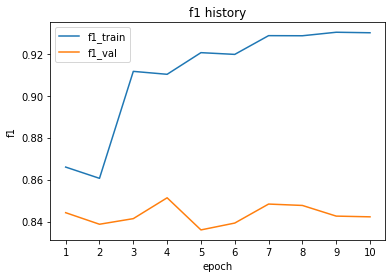

In [ ]:
fig, ax = plt.subplots()
ax.set_title("f1 history")
ax.set_ylabel("f1")
ax.set_xlabel("epoch")
plt.xticks(ticks=np.arange(0, epochs), labels=np.arange(1, epochs + 1))
history_df.loc[:,['f1_train', 'f1_val']].plot(ax=ax)
plt.savefig("f1.png")

Visualizzazione grafica della variazione dell'*accuracy_score* sul validation set al variare delle epoche.

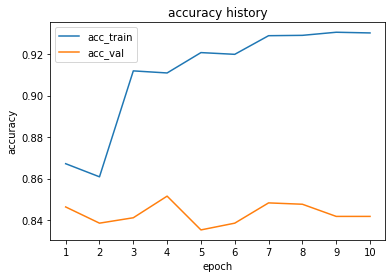

In [ ]:
fig, ax = plt.subplots()
ax.set_title("accuracy history")
ax.set_ylabel("accuracy")
ax.set_xlabel("epoch")
plt.xticks(ticks=np.arange(0, epochs), labels=np.arange(1, epochs + 1))
history_df.loc[:,['acc_train', 'acc_val']].plot(ax=ax)
plt.savefig("acc.png") 

La classificazione basata su BERT in genere ottiene ottimi risultati dopo poche epoche, questo è evidente dai 2 grafici (accuratezza training set e validation set), le prestazioni del nostro modello sul validation set sono già meglio rispetto ai precedenti modelli con 3 iterazioni.

## Testing and submission

Tokenizzazione del test set e applicazione del Dataloader in modo analogo a quanto fatto per il training set.

In [ ]:
test_tokens = []
test_attention_masks = []

for text in test:
    encoded_dict = tokenizer.encode_plus(text,
                                         add_special_tokens=True,
                                         max_length=sequence_length,
                                         padding="max_length",
                                         return_tensors='pt',
                                         truncation=True)
    test_tokens.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])
test_tokens = torch.cat(test_tokens, dim=0).to(device)
test_attention_masks = torch.cat(test_attention_masks, dim=0).to(device)


test_set = TensorDataset(test_tokens, test_attention_masks)
test_dataloader = DataLoader(test_set, 
                             sampler=SequentialSampler(test_set), 
                             batch_size=batch_size)

Fase di predizione fatta per ogni batch nel Dataloader, infine si sono unite tutte le previsioni all'interno del vettore `all_preds`

In [ ]:
all_preds = []

for batch in test_dataloader:
    x_batch, attention_mask = batch
    with torch.no_grad():
        probas = bert_clf(tokens=x_batch, attention_mask=attention_mask)
    preds = np.round(probas.cpu().detach().numpy()).astype(int).flatten()
    all_preds.extend(preds)

Salvataggio delle previsioni su un file .csv

In [ ]:
challenge_pred = pd.concat([pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Twitter fn/datasets/sample_submission.csv")["id"], pd.Series(all_preds)], axis=1)
challenge_pred.columns = ['id','target']
challenge_pred.to_csv("submissionBERT.csv", index=False)

## BERT results

Dopo esserci resi conto che questo modello è il più performante tra quelli testati ci siamo concentrati sul tuning dei parametri per ottenere una massimizzazione dello score finale. Inoltre abbiamo inserito diverse operazioni di feature engineering sul dataset finalizzate allo stesso obiettivo.

Di seguito vengono riportate le diverse configurazioni testate con i relativi risultati ottenuti:

> *Tentativo 1:*
*  `sequence_length = 64`
*  `batch_size = 16` 
*  *Cleaning* = No 
*  *Training_Dimension* = 0.8 
*  `Learning_rate = 2e-5`
*  *epochs* = 20
*  `dropout = 0.8`
*  **score = 0.83604**

> *Tentativo 2:*
*  `sequence_length = 64`
*  `batch_size = 16` 
*  *Cleaning* = No 
*  *Training_Dimension* = 0.75 
*  `Learning_rate = 2e-5`
*  *epochs* = 20
*  `dropout = 0.8`
*  **score = 0.82653**

> *Tentativo 3:*
*  `sequence_length = 64`
*  `batch_size = 16` 
*  *Cleaning* = Yes 
*  *Training_Dimension* = 0.8 
*  `Learning_rate = 2e-5`
*  *epochs* = 10
*  `dropout = 0.8`
*  **score = 0.83328**

> *Tentativo 4:*
*  `sequence_length = 64`
*  `batch_size = 16` 
*  *Cleaning* = Yes 
*  *Training_Dimension* = 0.8 
*  `Learning_rate = 2e-5`
*  *epochs* = 20
*  `dropout = 0.8`
*  **score = 0.80876**

> *Tentativo 5:*
*  `sequence_length = 64`
*  `batch_size = 16` 
*  *Cleaning* = Yes (con cleaning alternativo, poi eliminato)
*  *Training_Dimension* = 0.8 
*  `Learning_rate = 2e-5`
*  *epochs* = 10
*  `dropout = 0.8`
*  **score = 0.82408**

> *Tentativo 6:*
*  `sequence_length = 64`
*  `batch_size = 32` 
*  *Cleaning* = Yes 
*  *Training_Dimension* = 0.8 
*  `Learning_rate = 2e-5`
*  *epochs* = 10
*  `dropout = 0.8`
*  **score = 0.83818**

> *Tentativo 7:*
*  `sequence_length = 32`
*  `batch_size = 32` 
*  *Cleaning* = Yes 
*  *Training_Dimension* = 0.8 
*  `Learning_rate = 1e-5`
*  *epochs* = 10
*  `dropout = 0.8`
*  **score = 0.83083**

> *Tentativo 8:*
*  `sequence_length = 64`
*  `batch_size = 32` 
*  *Cleaning* = Yes 
*  *Training_Dimension* = 0.8 
*  `Learning_rate = 2e-5`
*  *epochs* = 10
*  `dropout = 0.25`
*  **score = 0.83879**

> *Tentativo 9:*
*  `sequence_length = 64`
*  `batch_size = 32` 
*  *Cleaning* = Yes 
*  *Training_Dimension* = 0.8 
*  `Learning_rate = 1e-5`
*  *epochs* = 10
*  `dropout = 0.25`
*  **score = 0.82868**

Al termine di tutti i test abbiamo ottenuto come score migliore **0.83879**, un risultato ben al di sopra degli altri modelli. Si noti però che BERT è un modello già pre-allenato e quindi questo risultato era prevedibile.

# Conclusions

In conclusione il modello più performante è risultato essere BERT, avendo prestazioni molto superiori a tutti gli altri. Tramite tuning dei parametri siamo riusciti a migliorare i risultati ottenuti con il modello di base e posizionarci 62esimi su 961 team in competizione. Inoltre c'è da considerare che le prime 19 posizioni sono ricoperte da utenti che usando un dataset espanso ottenendo uno score perfetto (1.00), quasi impossibile da avere altrimenti. 
Consideriamo questo un buon risultato per essere la nostra prima esperienza, poichè ci troviamo nel top 6% della leaderboard.

Escludendo BERT, tra gli altri modelli, le prestazioni migliori sono state ottenute da Extra trees che si è avvicinato allo score di 0.8.

Di seguito viene riportato un grafico riassuntivo degli score ottenuti nella competizione dai vari modelli (i BERT sono identificati dal numero di tentativo come descritto in precedenza).

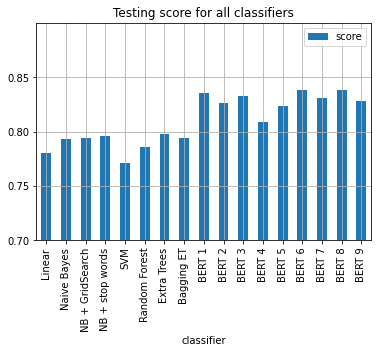

In [ ]:
df  = results

df.plot(title='Testing score for all classifiers', kind='bar', x='classifier',yticks=[0.7,0.75,0.8,0.85], grid=True, ylim=[0.7,0.9])  # plots all columns against index